In [1]:
#fetch command line argument (prepped model)
#%reset
import sys
import os
from copy import deepcopy
import pickle
import torch
import plotly.offline as py
import plotly.graph_objs as go


sys.path.insert(0, os.path.abspath('./prep_model_scripts/'))
sys.path.insert(0, os.path.abspath('./visualizer_scripts/'))
from visualizer_helper_functions import *
from contrast_helper_functions import *
from featureviz_helper_functions import *
from dissected_Conv2d import *
from copy import deepcopy


py.init_notebook_mode(connected=True)   #jupyter notebook only

prepped_model_folder = 'alexnet'    #set this to a subfolder of prunned_models

full_prepped_model_folder = os.path.abspath('prepped_models/%s'%prepped_model_folder)

possible_models = os.listdir('prepped_models')
print('possible models to visualizer are:')
print(possible_models)

print('\nYou\'ve chosen to visualize %s'%prepped_model_folder)


sys.path.insert(0,'prepped_models/%s'%prepped_model_folder)

import prep_model_params_used as prep_model_params

params = {}
params['prepped_model'] = prepped_model_folder
params['prepped_model_path'] = full_prepped_model_folder

possible models to visualizer are:
['mnist_resize', 'mnist_old', '.keep', 'mnist', 'alexnet10', 'alexnet10_test_old', 'letter_mixed_not_trained', 'alexnet10_test', 'alexnet_old', 'mnist.tgz', 'alexnet', 'letter_mixed', 'googlenet10_test', 'cifar10_old', 'googlenet10']

You've chosen to visualize alexnet


In [2]:
#Parameters

#Non-GUI parameters

#deepviz
params['deepviz_param'] = None
params['deepviz_optim'] = None
params['deepviz_transforms'] = None

#backend
params['cuda'] = prep_model_params.cuda    #use gpu acceleration when running model forward
params['input_image_directory'] = prep_model_params.input_img_path+'/'   #path to directory of imput images you want fed through the network
params['preprocess'] = prep_model_params.preprocess     #torchvision transfrom to pass input images through
params['label_file_path'] = prep_model_params.label_file_path
params['criterion'] = prep_model_params.criterion
params['rank_img_path'] = prep_model_params.rank_img_path
params['num_workers'] = prep_model_params.num_workers
params['seed'] = prep_model_params.seed
params['batch_size'] = prep_model_params.batch_size
#params['dynamic_act_cache_num'] = 4  #max number of input image activations 'dynamic_activations' will have simultaneously

 
#aesthetic 

params['node_size'] = 12
params['edge_size'] = 1
params['max_node_inputs'] = 20    #there is a dropdown showing the top weighted edge inputs to nodes, how many maps in dropdown?
params['layer_colors'] = ['rgba(31,119,180,', 
                          'rgba(255,127,14,',
                          'rgba(44,160,44,', 
                          'rgba(214,39,40,',
                          'rgba(39, 208, 214,', 
                          'rgba(242, 250, 17,',
                          'rgba(196, 94, 255,',
                          'rgba(193, 245, 5,',
                          'rgba(245, 85, 5,',
                          'rgba(5, 165, 245,',
                          'rgba(245, 5, 105,',
                          'rgba(218, 232, 23,',
                          'rgba(148, 23, 232,',
                          'rgba(23, 232, 166,',]




#GUI parameters initialization (these parameters can be set in the GUI, but what values should they be initialized to?)
target_category = 'overall'     #category of images edges and nodes are weighted based on (which subgraph) 
rank_type = 'actxgrad'       #weighting criterion (actxgrad, act, grad, or weight)
projection = 'MDS'           #how nodes within a layer are projected into the 2d plane (MDS or Grid)
edge_threshold = [.1,1]     #what range do edge ranks need to be in to be visualized


#### DONT EDIT BELOW initializations

figure_init = go.Figure()
figure_init.add_trace(go.Scatter(
            x=[],
            y=[]))
figure_init.update_layout(xaxis=dict(visible=False),
                  yaxis=dict(visible=False),
                  annotations = [dict(text="No Inputs",
                                      xref="paper",
                                      yref="paper",
                                      showarrow=False,
                                      font=dict(size=28))]
                 )

params['max_edge_weight'] = 1  #for the edge threshold slider, this dynamically adjusted its max value to max edge rank
                     #before there were multiple rank criterions, which made things confusing
                     #so well just fix it to 1 for now

In [3]:
#load Model

model_dis = dissect_model(deepcopy(prep_model_params.model),store_ranks=True,clear_ranks=True,cuda=params['cuda']) #version of model with accessible preadd activations in Conv2d modules 
if params['cuda']:
    model_dis.cuda()
model_dis = model_dis.eval()    

print('loaded model:')
print(prep_model_params.model)
        
#del prep_model_params.model
model = prep_model_params.model
if params['cuda']:
    model.cuda()
model = model.eval()


loaded model:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096

In [4]:
#load misc graph data
print('loading misc graph data')
misc_data = pickle.load(open('./prepped_models/%s/misc_graph_data.pkl'%prepped_model_folder,'rb'))
params['layer_nodes'] = misc_data['layer_nodes']
params['num_layers'] = misc_data['num_layers']
params['num_nodes'] = misc_data['num_nodes']
params['categories'] = misc_data['categories']
params['num_img_chan'] = misc_data['num_img_chan']
params['imgnode_positions'] = misc_data['imgnode_positions']
params['imgnode_colors'] = misc_data['imgnode_colors']
params['imgnode_names'] = misc_data['imgnode_names']
params['prepped_model_path'] = full_prepped_model_folder
params['ranks_data_path'] = full_prepped_model_folder+'/ranks/'


print('model has categories:')
print(params['categories'])

loading misc graph data
model has categories:
['overall', 'Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_elephant', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'American_chameleon', 'American_coot', 'American_egret', 'American_lobster', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'CD_player', 'Cardigan_corgi', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Crock_Pot', 'Dandie_Dinmont', 'Doberman', 'Dungeness_crab', 'Dutch_oven', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd

In [5]:
#load nodes df
print('loading nodes rank data')
target_node = 'loss'

categories_nodes_df = pd.read_csv('prepped_models/%s/ranks/categories_nodes_ranks.csv'%prepped_model_folder)
target_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]

weight_nodes_df = pd.read_csv('prepped_models/%s/ranks/weight_nodes_ranks.csv'%prepped_model_folder)

node_colors,node_weights = gen_node_colors(target_nodes_df,rank_type,params) 

#load node positions
print('loading node position data')
all_node_positions = pickle.load(open('./prepped_models/%s/node_positions.pkl'%prepped_model_folder,'rb'))

if projection == 'MDS':
    node_positions = all_node_positions[projection][rank_type+'_norm']
else:
    node_positions = all_node_positions[projection]



loading nodes rank data
loading node position data


In [6]:
#load edges
print('loading edge data')

categories_edges_df = None
if os.path.exists('prepped_models/%s/edge_ranks.csv'%prepped_model_folder):
    categories_edges_df = pd.read_csv('prepped_models/%s/ranks/categories_edges_ranks.csv'%prepped_model_folder)   #load edges

if categories_edges_df is not None:
    #overall_edges_df = categories_edges_df.loc[categories_edges_df['category']=='overall']
    target_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
else:
    #overall_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','overall_edges_rank.pt'))
    target_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))

    
weight_edges_df = pd.read_csv('prepped_models/%s/ranks/weight_edges_ranks.csv'%prepped_model_folder)
    
edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)
    
num_edges = len(target_edges_df)
edges_df_columns = list(target_edges_df.columns)

edge_positions, edge_colors, edge_widths, edge_weights, edge_names, max_edge_width_indices = gen_edge_graphdata(edges_thresholded_df, node_positions, rank_type, target_category,params)

loading edge data


In [7]:
#Load Edge Kernels
print('loading convolutional kernels')
kernels = torch.load('prepped_models/%s/kernels.pt'%prepped_model_folder)

loading convolutional kernels


In [8]:
#Input Image names
params['input_image_directory'] = prep_model_params.input_img_path+'/'
params['input_image_list'] = os.listdir(params['input_image_directory'])
params['input_image_list'].sort()
input_image_name = params['input_image_list'][0]

In [9]:
#Format Node Feature Maps
print('loading activation maps')

all_activations = {'nodes':{},'edges_in':{},'edges_out':{}}
if os.path.exists('prepped_models/%s/input_img_activations.pt'%prepped_model_folder):
    all_activations = torch.load('prepped_models/%s/input_img_activations.pt'%prepped_model_folder)


loading activation maps


In [10]:
#hidden state, stores python values within the html itself
state = {'projection':projection,'rank_type':rank_type,'edge_positions':edge_positions,'edge_colors': edge_colors, 'edge_widths':edge_widths,'edge_names':edge_names,
         'edge_threshold':edge_threshold,'edge_weights':edge_weights,'max_edge_width_indices':max_edge_width_indices,
         'node_positions':node_positions,'node_colors':node_colors,'node_weights':node_weights,'target_category':target_category,'target_node':'loss',
         'node_select_history':['0'],'edge_select_history':[edge_names[0][0]],'last_trigger':None,'input_image_name':input_image_name,
         'imgnode_positions':params['imgnode_positions'],'imgnode_colors':params['imgnode_colors'],'imgnode_names':params['imgnode_names']}


In [11]:
#App Component Layouts
axis=dict(showbackground=False,
          showspikes=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          #range=[0,0],
          title=''
          )

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.00, y=-1.25, z=1.25)
)


network_graph_layout = go.Layout(
         #title="%s through Prunned Cifar10 CNN"%target_category,
         #title = target_category,
         #width=1000,
         clickmode = 'event+select',
         transition = {'duration': 20},
         height=400,
         #showlegend=False,
         margin = dict(l=20, r=20, t=20, b=20),
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
             aspectmode ="manual", 
             aspectratio = dict(x=1, y=0.5, z=0.5) #adjusting this stretches the network layer-to-layer
         ),
         scene_camera = camera,
         uirevision =  True   
         #hovermode='closest',
   )


input_image_layout = go.Layout(#width=200, 
                      #height=200,
                      uirevision = True,
                      margin=dict(
                        l=12,
                        r=1,
                        b=12,
                        t=1,
                        pad=10
                        ),
                        paper_bgcolor='rgba(0,0,0,0)',
                        plot_bgcolor='rgba(0,0,0,0)',
                        xaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False),
                        yaxis=dict(range=(0,10),showline=False,showgrid=False,showticklabels=False))


node_actmap_layout = go.Layout(
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


edge_inmap_layout = go.Layout(
    #title = 'edge input map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


edge_outmap_layout = go.Layout(
    #title = 'edge output map',
    #autosize=False,
    #width=270,
    #height=200,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=10,
        pad=1
    ))


kernel_layout = go.Layout(
    #title='kernel'
    #autosize=False,
    #width=180,
    #height=120,
    uirevision = True,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=1
    ))


In [12]:
#Generate Network Graph
combined_traces = gen_networkgraph_traces(state,params,categories_nodes_df)
network_graph_fig=go.Figure(data=combined_traces, layout=network_graph_layout)

building graph from browser "state"


In [13]:
#Dash App Setup
print('setting up dash app')

import dash
import dash_core_components as dcc
import dash_html_components as html
#import utils.dash_reusable_components as drc
import flask
import os

import json

from dash.dependencies import Input, Output, State

from plotly.subplots import make_subplots

from flask_caching import Cache

#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(external_stylesheets = external_stylesheets)



if not os.path.exists(full_prepped_model_folder+'/cache/'):
    os.mkdir(full_prepped_model_folder+'/cache/')
CACHE_CONFIG = {
    # try 'filesystem' if you don't want to setup redis
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': full_prepped_model_folder+'/cache/'}
cache = Cache()
cache.init_app(app.server, config=CACHE_CONFIG)
    


styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


theme =  {
    'dark': True,
    'detail': '#007439',
    'primary': '#00EA64',
    'secondary': '#6E6E6E',
}


app.layout = html.Div([
        html.Div(
            children = [
                
            html.Div(
                #Left side control panel
                children = [
                 html.Label('Input'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Input(id='input-category',value=state['target_category']),
                html.Label('Output'),
                 #dcc.Dropdown(
                 #  id='weight-category',
                 #  options=[{'label': i, 'value': i} for i in params['categories']],
                 #   value=target_category
                 #   ),
                dcc.Dropdown(
                    id='target-node',
                    options=[
                    {'label': i, 'value': i} for i in ['loss']+[str(node) for node in list(range(params['num_nodes']))]
                    ],
                    value=state['target_node']),
                 html.Br(),
                 html.Label('Subgraph Criterion'),
                 dcc.Dropdown(
                    id='subgraph-criterion',
                    options=[
                        {'label': 'Activations*Grads', 'value': 'actxgrad'},
                        {'label': 'Activations', 'value': 'act'},
                        {'label': 'Gradients', 'value': 'grad'},
                        {'label': 'Weights', 'value': 'weight'}
                    ],
                    value='actxgrad'
                    ),
                 html.Br(),   
                 html.Label('Layer Projection'),
                 dcc.Dropdown(
                    id = 'layer-projection',
                    options=[
                        {'label': 'MDS', 'value': 'MDS'},
                        {'label': 'Grid', 'value': 'Grid'},
                        #{'label': 'SOM', 'value': 'SOM'}
                    ],
                    value='MDS'
                    ),

                html.Br(),
                html.Label('Edge Thresholds'),
                    dcc.RangeSlider(
                        id='edge-thresh-slider',
                        min=0,
                        max=np.ceil(params['max_edge_weight']*10)/10,
                        step=0.001,
                        marks={i/10: str(i/10) for i in range(0,int(np.ceil(params['max_edge_weight']*10))+1,int(round(np.ceil(params['max_edge_weight']*10)/5)))},
                        value=[.1,np.ceil(params['max_edge_weight']*10)/10],
                    ),

                ], className="two columns",
                ),
                
            html.Div([
                dcc.Graph(
                    id='network-graph',
                    figure=network_graph_fig
                )
                ], className= 'ten columns'
                ),
            ], className="row"
        ),


                
        html.Div([
            html.Div([
            html.Label('Input Image'),
            dcc.Dropdown(
                id='input-image-dropdown',
                options=[{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')],
                value=input_image_name
            ),
            html.Br(),
            dcc.Graph(
                id='img-actmap-graph',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=image2heatmap(params['input_image_directory']+input_image_name,input_image_layout),
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "two columns"),

            html.Div([
            html.Label('Node'),
            dcc.Dropdown(
                id='node-actmap-dropdown',
                options=[{'label': str(j), 'value': str(j)} for j in params['imgnode_names']]+[{'label': str(i), 'value': str(i)} for i in range(params['num_nodes'])],
                value='0'
            ),
            html.Br(),
            dcc.Graph(
                id='node-actmap-graph',
                style={
               'width': '19vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='node-deepviz-image',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "three columns"),
            
            html.Div([
            html.Label('Node Inputs'),
            html.Br(),
            html.Div(dcc.Graph(
                id='node-inputs-graph',
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),style={'overflowY': 'scroll', 'height': 500})
            ], className = "two columns"),

            html.Div([
            html.Label('Edge'),    
            dcc.Input(
                id='edge-actmaps-input',value=state['edge_names'][0][0], type='text'),
            #html.Button(id='edge-kernel-button',n_clicks=0, children='Submit'),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='edge-kernel-graph',
                style={
               'width': '14vw',
               'height':'10vw'
                },
                figure=go.Figure(data=go.Heatmap(
                                    z = edgename_2_edge_figures(state['edge_names'][0][0], input_image_name, kernels, None,params)[0]),
                                 layout=kernel_layout
                                ),
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            dcc.Graph(
                id='edge-deepviz-image',
                style={
               'width': '14vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )
            ], className = "two columns"),


            html.Div([
            html.Label('Edge Input'),
            html.Br(),
            dcc.Graph(
                id='edge-inmap-graph',
                style={
               'width': '19vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            ),
            html.Br(),
            html.Br(),
            html.Label('Edge Output'),
            html.Br(),
            dcc.Graph(
                id='edge-outmap-graph',
                style={
               'width': '19vw',
               'height':'14vw'
                },
                figure=figure_init,
                config={
                        'displayModeBar': False
                        }
            )

            ], className = "three columns")


         ], className= 'row'
         ),
                
                
        html.Div([
            html.Div([
                dcc.Markdown("""
                    **Hover Data**

                    Mouse over values in the graph.
                """),
                html.Pre(id='hover-data', style=styles['pre'])
            ], className='two columns'),

            html.Div([
                dcc.Markdown("""
                    **Click Data**

                    Click on points in the graph.
                """),
                html.Pre(id='click-data', style=styles['pre']),
            ], className='two columns'),

            html.Div([
                dcc.Markdown("""
                    **Selection Data**

                    Choose the lasso or rectangle tool in the graph's menu
                    bar and then select points in the graph.

                    Note that if `layout.clickmode = 'event+select'`, selection data also 
                    accumulates (or un-accumulates) selected data if you hold down the shift
                    button while clicking.
                """),
                html.Pre(id='selected-data', style=styles['pre']),
            ], className='two columns'),

#                 html.Div([
#                     dcc.Markdown("""
#                         **Zoom and Relayout Data**

#                         Click and drag on the graph to zoom or click on the zoom
#                         buttons in the graph's menu bar.
#                         Clicking on legend items will also fire
#                         this event.
#                     """),
#                     html.Pre(id='relayout-data', style=styles['pre']),
#                 ], className='two columns')
                
            html.Div([
                dcc.Markdown("""
                    **Figure Data**

                    Figure json info.
                """),
                html.Pre(id='figure-data', style=styles['pre']),
            ], className='four columns')

        ], className= 'row'
        ),

    #hidden divs for storing intermediate values     
    # The memory store reverts to the default on every page refresh
    dcc.Store(id='memory',data=state),
    # The local store will take the initial data
    # only the first time the page is loaded
    # and keep it until it is cleared.
    #dcc.Store(id='local', storage_type='local'),
    # Same as the local store but will lose the data
    # when the browser/tab closes.
    #dcc.Store(id='session', storage_type='session',data=state),
    

    # hidden signal value
    html.Div(id='input-image-signal',  style={'display': 'none'}),
    html.Div(id='target-signal', style={'display': 'none'},children = [state['target_category'],state['target_node']])

])



# perform expensive computations in this "global store"
# these computations are cached in a globally available
# redis memory store which is available across processes
# and for all time.
@cache.memoize()
def activations_store(image_name):

    print('Updating cached activations with {}'.format(image_name))
    activations = get_model_activations_from_image(get_image_path(image_name,params)[1], model_dis, params)
    
    return activations

@app.callback(Output('input-image-signal', 'children'), 
              [Input('input-image-dropdown', 'value')])
def update_activations_store(image_name):
    # compute value and send a signal when done
    activations_store(image_name)
    return image_name


@cache.memoize()
def ranksdf_store(target_category, target_node,model_dis=model_dis):
    print('Updating cached rank dfs with {}'.format(target_category))
    model_dis = clear_ranks_across_model(model_dis)
    target_type = image_category_or_contrast(target_category,params)
    target_category_nodes_df = None
    target_category_edges_df = None
    if target_type == 'category' and target_node == 'loss':
        #edges
        if categories_edges_df is not None:
            if len(categories_edges_df.loc[categories_edges_df['category']==target_category]) > 0:
                target_category_edges_df = categories_edges_df.loc[categories_edges_df['category']==target_category]
        if target_category_edges_df is None:
            target_category_edges_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_edges','%s_edges_rank.pt'%target_category))   
        #node
        if categories_nodes_df is not None:
            if len(categories_nodes_df.loc[categories_nodes_df['category']==target_category]) > 0:
                target_category_nodes_df = categories_nodes_df.loc[categories_nodes_df['category']==target_category]
        if target_category_nodes_df is None:
            target_category_nodes_df = rank_file_2_df(os.path.join(params['ranks_data_path'],'categories_nodes','%s_nodes_rank.pt'%target_category))
    elif target_type == 'category':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_for_category(target_category, target_node, model_dis,params))
    elif target_type == 'input_image':
        target_category_nodes_df,target_category_edges_df = rank_dict_2_df(get_model_ranks_from_image(get_image_path(target_category,params)[1],target_node, model_dis, params))
        print(target_category_nodes_df.head(5))
        print(target_category_edges_df.head(5))
    else:  #contrast
        target_category_nodes_df,target_category_edges_df = contrast_str_2_dfs(target_category,target_node,model_dis,params)

    return target_category_nodes_df,target_category_edges_df

@app.callback(Output('target-signal', 'children'), 
              [Input('input-category', 'value'),
               Input('target-node','value')])
def update_ranksdf_store(target_category,target_node):
    # compute value and send a signal when done
    print('update ranksdf_store triggered')
    ranksdf_store(target_category,target_node)
    return [target_category,target_node]



####Call Back Functions

#Hidden State
@app.callback(
    Output('memory', 'data'),
    [Input('target-signal', 'children'),
     Input('node-actmap-dropdown', 'value'),
     Input('edge-actmaps-input', 'value'),
     Input('edge-thresh-slider','value'),
     Input('layer-projection','value'),
     Input('subgraph-criterion','value')],
    [State('memory', 'data')])
def update_store(target,node_value,edge_value,edge_threshold,projection,rank_type,state):
    print('CALLED: update_store\n')
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id']
    state['last_trigger'] = trigger  #store the last trigger of state change in state
    print('TRIGGER %s'%trigger)

    target_category,target_node = target[0],target[1]
    #fetch select edges DF
    if trigger in ['target-signal.children','edge-thresh-slider.value','layer-projection.value','subgraph-criterion.value']:
        if rank_type == 'weight':
            target_edges_df = weight_edges_df
            target_nodes_df = weight_nodes_df
            edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)
        else:   
            target_nodes_df,target_edges_df = ranksdf_store(target_category,target_node)
            edges_thresholded_df = get_thresholded_edges(edge_threshold,rank_type,target_edges_df,target_category)

    if trigger == 'target-signal.children':
        print('changing target category to %s'%target_category)
        print(target_nodes_df)
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['max_edge_weight'] = get_max_edge_weight(target_category)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'node-actmap-dropdown.value' or trigger == 'edge-actmaps-input.value':
        state['last_trigger'] = 'selection_change'
        print(edge_value)
        #update node if button value different than store value
        if state['node_select_history'][-1] != node_value:
            print('changing selected node to %s'%node_value)
            state['node_select_history'].append(node_value)
            if len(state['node_select_history']) > 10:
                del state['node_select_history'][0] 
        #update edge if button value different than store value
        if state['edge_select_history'][-1] != edge_value and check_edge_validity(edge_value.strip(),params)[0]:
            print('changing selected edge to %s'%edge_value)
            state['edge_select_history'].append(edge_value)
            print(state['edge_select_history'])
            if len(state['edge_select_history']) > 10:
                del state['edge_select_history'][0]              

    elif trigger == 'edge-thresh-slider.value':
        print('changing edge thresholds to %s - %s'%(edge_threshold[0],edge_threshold[1]))
        state['edge_threshold'] == edge_threshold
        print('found %s edges'%len(edges_thresholded_df))
        state['edge_positions'], state['edge_colors'], state['edge_widths'], state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'layer-projection.value':
        print('changing layer projection to %s\n'%projection)
        state['projection']=projection
        if projection == 'MDS':
            state['node_positions'] = all_node_positions[projection][rank_type+'_norm']
        else:
            state['node_positions'] = all_node_positions[projection]
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    elif trigger == 'subgraph-criterion.value':
        print('changing weighting criterion to %s\n'%rank_type)
        state['rank_type']=rank_type
        state['node_colors'], state['node_weights'] = gen_node_colors(target_nodes_df,rank_type,params)
        #state['node_positions']=format_node_positions(projection=projection,rank_type=rank_type)
        state['edge_positions'], state['edge_colors'], state['edge_widths'],state['edge_weights'], state['edge_names'], state['max_edge_width_indices'] = gen_edge_graphdata(edges_thresholded_df, state['node_positions'], rank_type, target_category,params)

    else:
        raise Exception('unknown trigger: %s'%trigger)    
    return state


#Network Graph Figure
@app.callback(
    Output('network-graph', 'figure'),
    [Input('memory', 'data')],
    [State('network-graph','figure')])
def update_figure(state, fig):
    #network_graph_layout['uirevision'] = True
    print('CALLED: update_figure\n')
    print(state['edge_threshold'])
    print(state['edge_select_history'])
    print(state['node_select_history'])
    if state['last_trigger'] == 'selection_change':   #minimal updates
        #hightlight edge
        print('updating edge highlight to %s'%state['edge_select_history'][-1])
        #if len(state['edge_select_history']) >1:
        #if state['edge_select_history'][-1] != state['edge_select_history'][-2]:  #didnt click same point
        flat_edge_names = [item for sublist in state['edge_names'] for item in sublist]
        flat_edge_colors = [item for sublist in state['edge_colors'] for item in sublist]
        try:  #update current edge if it exists to black
            #print(flat_edge_names)
            fig['data'][flat_edge_names.index(state['edge_select_history'][-1])+params['num_layers']+1]['line']['color'] = 'rgba(0,0,0,1)'
        except:
            print('select edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-1])
        if len(state['edge_select_history']) > 1: #there is a previous edge to unselect
            try: #recolor previous edge if it exists from black
                fig['data'][flat_edge_names.index(state['edge_select_history'][-2])+params['num_layers']+1]['line']['color'] = flat_edge_colors[flat_edge_names.index(state['edge_select_history'][-2])]
            except:
                print('previous edge, %s,  not recolored as no longer shown'%state['edge_select_history'][-2])
        #highlight node
        print('updating node highlight to %s'%state['node_select_history'][-1])
        #if len(state['node_select_history']) >1:
        #    if state['node_select_history'][-1] != state['node_select_history'][-2]: 
                #update current node color to black
        if str(state['node_select_history'][-1]).isnumeric():  #if normal node
            select_layer,select_position,select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-1],params)
            fig['data'][select_layer+1]['marker']['color'][select_position] = 'rgba(0,0,0,1)'
        else:   #imgnode
            fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-1])] = 'rgba(0,0,0,1)'
        #update previous node color to its usual color
        if len(state['node_select_history']) > 1: #there is a previous node to unselect
            if str(state['node_select_history'][-2]).isnumeric():  #if normal node
                prev_select_layer,prev_select_position,prev_select_layer_name = nodeid_2_perlayerid(state['node_select_history'][-2],params)
                print(prev_select_layer,prev_select_position,prev_select_layer_name)
                fig['data'][prev_select_layer+1]['marker']['color'][prev_select_position] = state['node_colors'][prev_select_layer][prev_select_position]
            else:   #imgnode
                fig['data'][0]['marker']['color'][fig['data'][0]['text'].index(state['node_select_history'][-2])] = state['imgnode_colors'][fig['data'][0]['text'].index(state['node_select_history'][-2])]
        #fig['layout']['uirevision']=True   
        return fig    
    else:   #regenerate full traces
        combined_traces = gen_networkgraph_traces(state,params,categories_nodes_df)
        fig['data'] = combined_traces
        #layout = network_graph_layout
        #layout['uirevision'] = True
        return fig

#Node Actmap Dropdown
@app.callback(
    Output('node-actmap-dropdown', 'value'),
    [Input('network-graph', 'clickData')],
    [State('node-actmap-dropdown', 'value')])
def switch_node_actmap_click(clickData,current_value):
    print('CALLED: switch_node_actmap_click')
    if clickData is None:
        return current_value 
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) > params['num_layers']:
        return current_value
        #raise Exception('edge was clicked')
    return clickData['points'][0]['text']

#Edge Actmaps Input
@app.callback(
    Output('edge-actmaps-input', 'value'),
    [Input('network-graph', 'clickData')],
    [State('edge-actmaps-input', 'value'),
     State('memory', 'data')])
def switch_edge_actmaps_click(clickData,current_value,state):
    print('CALLED: switch_edge_actmaps_click')
    if clickData is None:
        return current_value
        #raise Exception('no click data')
    if int(clickData['points'][0]['curveNumber']) <= params['num_layers']:
        return current_value
        #raise Exception('node was clicked')
    return get_nth_element_from_nested_list(state['edge_names'],int(clickData['points'][0]['curveNumber'])-(params['num_layers']+1))


#Node actmap graph
@app.callback(
    Output('node-actmap-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('input-image-signal', 'children')])
def update_node_actmap(nodeid,image_name):       #EDIT: needs support for black and white images
    print('CALLED: update_node_actmap')
    layer, within_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations  = activations_store(image_name)
        
    if layer == 'img': #code for returning color channel as activation map
        #np_chan_im = get_channelwise_image(image_name,state['imgnode_names'].index(nodeid),params['input_image_directory']=params['input_image_directory'])
        np_chan_im = activations['edges_in'][image_name][0][within_id]
        return go.Figure(data=go.Heatmap( z = np.flip(np_chan_im,0)),
                        layout=node_actmap_layout) 
    
    return go.Figure(data=go.Heatmap( z = np.flip(activations['nodes'][image_name][layer][within_id],0),
                                      #zmin=-1,
                                      #zmax=1,
                                      colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                    ),
                     layout=node_actmap_layout) 


#Node deepviz graph
@app.callback(
    Output('node-deepviz-image', 'figure'),
    [Input('node-actmap-dropdown', 'value')])
def update_node_deepviz(nodeid):       #EDIT: needs support for black and white images
    print('CALLED: update_node_deepviz')
    layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    if layer == 'img': 
        return figure_init
    image_name = fetch_deepviz_img(model,str(nodeid),params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
    

#Edge deepviz graph
@app.callback(
    Output('edge-deepviz-image', 'figure'),
    [Input('edge-actmaps-input', 'value')])
def update_edge_deepviz(edgename):       #EDIT: needs support for black and white images
    print('CALLED: update_edge_deepviz')
    #layer,within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)    
    #if layer == 'img': 
    #    return figure_init
    image_name = fetch_deepviz_img(model_dis,edgename,params)
    image_path = params['prepped_model_path']+'/visualizations/images/'+image_name
    return image2plot(image_path,input_image_layout)
        

#Node inputs actmap graph
@app.callback(
    Output('node-inputs-graph', 'figure'),
    [Input('node-actmap-dropdown', 'value'),
     Input('input-image-signal', 'children'),
     Input('target-signal', 'children'),
     Input('subgraph-criterion','value')])
def update_node_inputs(nodeid,image_name,target,rank_type,max_num = params['max_node_inputs']):       
    print('CALLED: update_node_inputs')
    target_category,target_node = target[0],target[1]
    node_layer,node_within_layer_id,layer_name = nodeid_2_perlayerid(nodeid,params)
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations_store(image_name)
    #fetch edges df
    if rank_type == 'weight':
        target_edges_df = weight_edges_df
    else:
        target_edges_df = ranksdf_store(target_category,target_node)[1]
    #return no input if on input image node 
    if node_layer == 'img':
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=[],
            y=[]))
        fig.update_layout(xaxis=dict(visible=False),
                          yaxis=dict(visible=False),
                          annotations = [dict(text="No Inputs",
                                              xref="paper",
                                              yref="paper",
                                              showarrow=False,
                                              font=dict(size=28))]
                         )
        return fig

    all_node_edges_df = target_edges_df.loc[(target_edges_df['layer']==node_layer) & (target_edges_df['out_channel'] == node_within_layer_id)]
    #if sort_images:                      
    all_node_edges_df = all_node_edges_df.sort_values(by=[rank_type+'_norm_rank'],ascending=False)
    top_node_edges_df = all_node_edges_df.head(max_num)
    fig = make_subplots(rows=len(top_node_edges_df)+1, cols=1)
    print(top_node_edges_df)
    i=1
    for row in top_node_edges_df.itertuples():
        if node_layer == 0:
            edge_name = str(params['imgnode_names'][row.in_channel])+'-'+str(nodeid)
        else:
            edge_name = str(params['layer_nodes'][node_layer-1][1][row.in_channel])+'-'+str(nodeid)

        fig.add_trace(
               go.Heatmap(z = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)[2],
                          #zmin = -1,
                          #zmax = 1,
                          name = edge_name,
                          showscale = False,
                          colorbar = dict(lenmode='fraction',len=1/len(top_node_edges_df), 
                                          y=(i)/len(top_node_edges_df)-.01,
                                          thicknessmode = "fraction",thickness=.1,
                                          ypad=1
                                         )),
               row=i, col=1)
        i+=1
    fig.update_layout(height=200*len(top_node_edges_df), 
                      width=170,
                      #yaxis=dict(scaleanchor="x", scaleratio=1/len(top_node_edges_df)),
                      #title_text="Inputs to Node",
                      margin=dict(
                                    l=0,
                                    r=0,
                                    b=0,
                                    t=0,
                                    pad=0)
                     )
    return fig

#image graph
@app.callback(
    Output('img-actmap-graph', 'figure'),
    [Input('input-image-dropdown', 'value')])
def update_inputimg_actmap(image_name): 
    print('CALLED: update_inputimg_actmap')
    #if os.path.exists(params['input_image_directory']+image_name):
    return image2plot(get_image_path(image_name,params)[1],input_image_layout)
    #else:
        #return image2plot(params['prepped_model_path']+'/visualizations/'+image_name,input_image_layout)
    
#image dropdown
@app.callback(
    Output('input-image-dropdown', 'options'),
    [Input('node-deepviz-image', 'figure'),
     Input('edge-deepviz-image', 'figure')])
def update_inputimg_dropdown(node_fig,edge_fig): 
    print('CALLED: update_inputimg_dropdown options')
    return [{'label': i, 'value': i} for i in params['input_image_list']+os.listdir(params['prepped_model_path']+'/visualizations/images/')]


#kernel
@app.callback(
    Output('edge-kernel-graph', 'figure'),
    [Input('edge-actmaps-input','value')],
    [State('edge-kernel-graph','figure')])
def update_edge_kernelmap(edge_name,figure):
    print('CALLED: update_edge_kernelmap')
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, None, kernels, None,params)
    if kernel is not None:
        return go.Figure(data=go.Heatmap(z = kernel
                                         #zmin=-.5,
                                         #zmax=.5
                                        ),
                         layout=kernel_layout)
    else:
        return figure
                

#edge in        
@app.callback(
    Output('edge-inmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-inmap-graph','figure')])
def update_edge_inmap(edge_name,image_name,figure):
    print('CALLED: update_edge_inmap')
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations = activations_store(image_name)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if inmap is not None:
        return go.Figure(data=go.Heatmap(z = inmap,zmin=-1,zmax=1,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_inmap_layout)
    else:
        print('edge inmap error')
        return figure

#edge out
@app.callback(
    Output('edge-outmap-graph', 'figure'),
    [Input('edge-actmaps-input','value'),
     Input('input-image-signal', 'children')],
    [State('edge-outmap-graph','figure')])
def update_edge_outmap(edge_name,image_name,figure):
    print('CALLED: update_edge_outmap')
    #fetch activations
    if image_name in all_activations['nodes']:
        activations = all_activations
    else:
        activations = activations = activations_store(image_name)
        
    kernel,inmap,outmap = edgename_2_edge_figures(edge_name, image_name, kernels, activations,params)
    if outmap is not None:
        return go.Figure(data=go.Heatmap(z = outmap,
                                         #zmin=-1,
                                         #zmax=1,
                                         colorbar = dict(thicknessmode = "fraction",thickness=.1)
                                        ),
                         layout=edge_outmap_layout)
    else:
        print('edge outmap error')
        return figure
        
        

# #JSON INFO

@app.callback(
    Output('hover-data', 'children'),
    [Input('network-graph', 'hoverData')])
def display_hover_data(hoverData):
    return json.dumps(hoverData, indent=2)




@app.callback(
    Output('click-data', 'children'),
    [Input('network-graph', 'clickData')])
def display_click_data(clickData):
    return json.dumps(clickData, indent=2)


@app.callback(
    Output('selected-data', 'children'),
    [Input('network-graph', 'selectedData')])
def display_selected_data(selectedData):
    return json.dumps(selectedData, indent=2)


@app.callback(
    Output('figure-data', 'children'),
    [Input('input-category', 'value'),
     Input('network-graph', 'clickData'),
     Input('edge-thresh-slider','value'),
     Input('memory','data')])
def display_trigger(target_category,clickData,edge_thresh,state):
    ctx = dash.callback_context
    if not ctx.triggered:
        raise Exception('no figure updates yet')
    else:
        trigger = ctx.triggered[0]['prop_id'].split('.')[0]
    ctx_msg = json.dumps({
        'states': ctx.states,
        'triggered': ctx.triggered,
        'inputs': ctx.inputs,
        'full_state':state
    }, indent=2)
    return ctx_msg

setting up dash app


Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_6_0m1596203731.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_6_0m1596203731.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_renderer/react@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.v1_10_2m1596203744.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:52] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_10_2m1596203744.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 2

update ranksdf_store triggered
CALLED: update_inputimg_actmap
Updating cached rank dfs with overall
Updating cached activations with Afghan_hound_10.JPEG


127.0.0.1 - - [11/Dec/2020 20:34:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:57] "GET /_dash-component-suites/dash_core_components/async-graph.v1_10_2m1595872686.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:57] "GET /_dash-component-suites/dash_core_components/async-plotlyjs.v1_10_2m1595872686.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:57] "GET /_dash-component-suites/dash_core_components/async-markdown.v1_10_2m1595872686.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:34:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:04] "GET /_dash-component-suites/dash_core_components/async-highlight.v1_10_2m1595872686.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 20:35:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
found pre-generated image
CALLED: update_node_actmap
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 20:35:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-2


127.0.0.1 - - [11/Dec/2020 20:35:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0']
updating edge highlight to r-2
updating node highlight to 0


127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options
   edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
1         1  features_0      0            0           1          1.880616   
0         0  features_0      0            0           0          1.413178   
2         2  features_0      0            0           2          0.511277   

   grad_prenorm_rank  actxgrad_prenorm_rank  act_norm_rank  grad_norm_rank  \
1            0.00001               0.000035       0.087798        0.037286   
0            0.00001               0.000023       0.065940        0.037286   
2            0.00001               0.000010       0.023905        0.037286   

   actxgrad_norm_rank  
1            0.080289  
0            0.052224  
2            0.023560  


127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:56] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_10_2m1596203744.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:56] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_6_0m1596203731.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:35:56] "GET /_dash-component-suites/dash_renderer/react@16.v1_6_0m1596203731.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/

update ranksdf_store triggered
CALLED: update_inputimg_actmap


127.0.0.1 - - [11/Dec/2020 20:36:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:28] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_node_actmapCALLED: update_node_deepviz

found pre-generated image
CALLED: update_node_inputs


127.0.0.1 - - [11/Dec/2020 20:36:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-2


127.0.0.1 - - [11/Dec/2020 20:36:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:36:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -


   edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
1         1  features_0      0            0           1          1.880616   
0         0  features_0      0            0           0          1.413178   
2         2  features_0      0            0           2          0.511277   

   grad_prenorm_rank  actxgrad_prenorm_rank  act_norm_rank  grad_norm_rank  \
1            0.00001               0.000035       0.087798        0.037286   
0            0.00001               0.000023       0.065940        0.037286   
2            0.00001               0.000010       0.023905        0.037286   

   actxgrad_norm_rank  
1            0.080289  
0            0.052224  
2            0.023560  


127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0']
updating edge highlight to r-2
updating node highlight to 0


127.0.0.1 - - [11/Dec/2020 20:36:32] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:36:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:49] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with t
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/fla

127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with ti
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/fl

127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
update ranksdf_store triggered
Updating cached rank dfs with tig
Updating cached rank dfs with tige
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/ho

127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [11/Dec/2020 20:36:51] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tiger


127.0.0.1 - - [11/Dec/2020 20:36:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_store

TRIGGER target-signal.children
changing target category to tiger
         node_num   layer_name  layer  node_num_by_layer  act_prenorm_rank  \
1039104         0   features_0      0                  0          0.341375   
1039105         1   features_0      0                  1          0.342815   
1039106         2   features_0      0                  2          0.493653   
1039107         3   features_0      0                  3          0.507939   
1039108         4   features_0      0                  4          0.630259   
...           ...          ...    ...                ...               ...   
1040251      1147  features_10      4                251          0.138633   
1040252      1148  features_10      4                252          0.232776   
1040253      1149  features_10      4                253          0.192005   
1040254      1150  features_10      4                254          0.848391   
1040255      1151  features_

127.0.0.1 - - [11/Dec/2020 20:36:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:54] "POST /_dash-update-component HTTP/1.1" 200 -


   edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
1         1  features_0      0            0           1          2.302351   
0         0  features_0      0            0           0          1.736463   
2         2  features_0      0            0           2          0.576173   

   grad_prenorm_rank  actxgrad_prenorm_rank  act_norm_rank  grad_norm_rank  \
1           0.000006               0.000020       0.113297        0.047921   
0           0.000006               0.000013       0.085450        0.047921   
2           0.000006               0.000006       0.028353        0.047921   

   actxgrad_norm_rank  
1            0.097043  
0            0.060426  
2            0.030740  


127.0.0.1 - - [11/Dec/2020 20:36:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:36:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:36:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:37:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image


127.0.0.1 - - [11/Dec/2020 20:37:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-2
changing selected node to 686
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686']
updating edge highlight to r-2
updating node highlight to 686
0 0 features_0


127.0.0.1 - - [11/Dec/2020 20:37:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:07] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:37:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:07] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
104019    104019  features_8      3           46         147   
104166    104166  features_8      3           46         294   
104252    104252  features_8      3           46         380   
104090    104090  features_8      3           46         218   
103886    103886  features_8      3           46          14   
103959    103959  features_8      3           46          87   
103890    103890  features_8      3           46          18   
104105    104105  features_8      3           46         233   
104074    104074  features_8      3           46         202   
104063    104063  features_8      3           46         191   
103970    103970  features_8      3           46          98   
104031    104031  features_8      3           46         159   
104101    104101  features_8      3           46         229   
104211    104211  features_8      3           46         339   
104206    104206  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:37:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmapCALLED: update_store

TRIGGER edge-actmaps-input.value
r-2
changing selected node to 874



127.0.0.1 - - [11/Dec/2020 20:37:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:37:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874']
updating edge highlight to r-2
updating node highlight to 874
3 46 features_8


127.0.0.1 - - [11/Dec/2020 20:37:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:26] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
176247    176247  features_8      3          234         183   
176223    176223  features_8      3          234         159   
176243    176243  features_8      3          234         179   
176437    176437  features_8      3          234         373   
176134    176134  features_8      3          234          70   
176280    176280  features_8      3          234         216   
176447    176447  features_8      3          234         383   
176230    176230  features_8      3          234         166   
176157    176157  features_8      3          234          93   
176213    176213  features_8      3          234         149   
176321    176321  features_8      3          234         257   
176206    176206  features_8      3          234         142   
176224    176224  features_8      3          234         160   
176440    176440  features_8      3          234         376   
176073    176073  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:37:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
Updating cached activations with tiger_10006.JPEG


127.0.0.1 - - [11/Dec/2020 20:37:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:37:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:37:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:37:55] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
176247    176247  features_8      3          234         183   
176223    176223  features_8      3          234         159   
176243    176243  features_8      3          234         179   
176437    176437  features_8      3          234         373   
176134    176134  features_8      3          234          70   
176280    176280  features_8      3          234         216   
176447    176447  features_8      3          234         383   
176230    176230  features_8      3          234         166   
176157    176157  features_8      3          234          93   
176213    176213  features_8      3          234         149   
176321    176321  features_8      3          234         257   
176206    176206  features_8      3          234         142   
176224    176224  features_8      3          234         160   
176440    176440  features_8      3          234         376   
176073    176073  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:38:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:38:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:38:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:38:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:39:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:11] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with tiger
batch 0
target reached, breaking model forward pass in features_8
234
tensor(-1.3656, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 1
target reached, breaking model forward pass in features_8
234
tensor(-1.4022, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 2
target reached, breaking model forward pass in features_8
234
tensor(-2.6715, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 3
target reached, breaking model forward pass in features_8
234
tensor(-2.0525, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass
batch 4
target reached, breaking model forward pass in features_8
234
tensor(-1.8157, device='cuda:0', grad_fn=<SelectBackward>)
target node 874 reached, halted forward pass


127.0.0.1 - - [11/Dec/2020 20:40:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
Updating cached activations with tiger_10006.JPEG
CALLED: update_store

TRIGGER target-signal.children
changing target category to tiger
      node_num   layer_name  layer  node_num_by_layer  act_prenorm_rank  \
0            0   features_0      0                  0          0.312575   
1            1   features_0      0                  1          0.358834   
2            2   features_0      0                  2          0.485982   
3            3   features_0      0                  3          0.406480   
4            4   features_0      0                  4          0.627336   
...        ...          ...    ...                ...               ...   
1147      1147  features_10      4                251          0.000000   
1148      1148  features_10      4                252          0.000000   
1149      1149  features_10      4                253          0.000000   
1150      1150  features_10      4                254          0.000000   
1151      1

127.0.0.1 - - [11/Dec/2020 20:40:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:31] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:40:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:40:37] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
176360    176360  features_8      3          234         296   
176082    176082  features_8      3          234          18   
176163    176163  features_8      3          234          99   
176232    176232  features_8      3          234         168   
176114    176114  features_8      3          234          50   
176213    176213  features_8      3          234         149   
176187    176187  features_8      3          234         123   
176247    176247  features_8      3          234         183   
176444    176444  features_8      3          234         380   
176440    176440  features_8      3          234         376   
176445    176445  features_8      3          234         381   
176117    176117  features_8      3          234          53   
176132    176132  features_8      3          234          68   
176230    176230  features_8      3          234         166   
176243    176243  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:40:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:58] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 20:41:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:41:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_deepviz
found pre-generated image
CALLED: update_node_inputs


127.0.0.1 - - [11/Dec/2020 20:42:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-2
changing selected node to 787


127.0.0.1 - - [11/Dec/2020 20:42:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
CALLED: update_edge_inmap
['r-2']
['0', '686', '874', '787']
updating edge highlight to r-2
updating node highlight to 787
3 234 features_8
CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:02] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
142656    142656  features_8      3          147           0   
142657    142657  features_8      3          147           1   
142918    142918  features_8      3          147         262   
142917    142917  features_8      3          147         261   
142916    142916  features_8      3          147         260   
142915    142915  features_8      3          147         259   
142914    142914  features_8      3          147         258   
142913    142913  features_8      3          147         257   
142912    142912  features_8      3          147         256   
142911    142911  features_8      3          147         255   
142910    142910  features_8      3          147         254   
142909    142909  features_8      3          147         253   
142908    142908  features_8      3          147         252   
142907    142907  features_8      3          147         251   
142906    142906  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:42:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:42:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:43:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_deepviz
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
CALLED: update_store

CALLED: update_edge_kernelmap
TRIGGER edge-actmaps-input.value
r-2found pre-generated image



127.0.0.1 - - [11/Dec/2020 20:43:24] "POST /_dash-update-component HTTP/1.1" 200 -


changing selected node to 874


127.0.0.1 - - [11/Dec/2020 20:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
        edge_num  layer_name  layer  out_channel  in_channel  \
176360    176360  features_8      3          234         296   
176082    176082  features_8      3          234          18   
176163    176163  features_8      3          234          99   
176232    176232  features_8      3          234         168   
176114    176114  features_8      3          234          50   
176213    176213  features_8      3          234         149   
176187    176187  features_8      3          234         123   
176247    176247  features_8      3          234         183   
176444    176444  features_8      3          234         380   
176440    176440  features_8      3          234         376   
176445    176445  features_8      3          234         381   
176117    176117  features_8      3          234          53   
176132    176132  features_8      3          234          68   
176230    176230  features_8      3          234         166   
176243    176

127.0.0.1 - - [11/Dec/2020 20:43:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874', '787', '874']
updating edge highlight to r-2
updating node highlight to 874
3 147 features_8


127.0.0.1 - - [11/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:43:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_node_inputs
CALLED: update_store

TRIGGER subgraph-criterion.value
changing weighting criterion to act



127.0.0.1 - - [11/Dec/2020 20:44:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:38] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
176360    176360  features_8      3          234         296   
176082    176082  features_8      3          234          18   
176163    176163  features_8      3          234          99   
176232    176232  features_8      3          234         168   
176114    176114  features_8      3          234          50   
176213    176213  features_8      3          234         149   
176187    176187  features_8      3          234         123   
176247    176247  features_8      3          234         183   
176444    176444  features_8      3          234         380   
176440    176440  features_8      3          234         376   
176445    176445  features_8      3          234         381   
176117    176117  features_8      3          234          53   
176132    176132  features_8      3          234          68   
176230    176230  features_8      3          234         166   
176243    176243  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874', '787', '874']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:44:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.

update ranksdf_store triggered
Updating cached rank dfs with tiger


127.0.0.1 - - [11/Dec/2020 20:45:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_store

TRIGGER target-signal.children
changing target category to tiger
         node_num   layer_name  layer  node_num_by_layer  act_prenorm_rank  \
1039104         0   features_0      0                  0          0.341375   
1039105         1   features_0      0                  1          0.342815   
1039106         2   features_0      0                  2          0.493653   
1039107         3   features_0      0                  3          0.507939   
1039108         4   features_0      0                  4          0.630259   
...           ...          ...    ...                ...               ...   
1040251      1147  features_10      4                251          0.138633   
1040252      1148  features_10      4                252          0.232776   
1040253      1149  features_10      4                253          0.192005   
1040254      1150  features_10      4                254          0.848391   
1040255      1151  features_

127.0.0.1 - - [11/Dec/2020 20:45:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:22] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
176360    176360  features_8      3          234         296   
176187    176187  features_8      3          234         123   
176444    176444  features_8      3          234         380   
176213    176213  features_8      3          234         149   
176114    176114  features_8      3          234          50   
176163    176163  features_8      3          234          99   
176440    176440  features_8      3          234         376   
176247    176247  features_8      3          234         183   
176082    176082  features_8      3          234          18   
176445    176445  features_8      3          234         381   
176280    176280  features_8      3          234         216   
176289    176289  features_8      3          234         225   
176230    176230  features_8      3          234         166   
176243    176243  features_8      3          234         179   
176447    176447  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:45:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:25] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874', '787', '874']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:45:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:45:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
Updating cached activations with tiger_10006.JPEG
Updating cached activations with tiger_10006.JPEG
CALLED: update_edge_deepviz


127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
r-2
changing selected node to 8


127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
Updating cached activations with tiger_10006.JPEG
CALLED: update_edge_inmap
Updating cached activations with tiger_10006.JPEG


127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874', '787', '874', '8']
updating edge highlight to r-2
updating node highlight to 8
3 234 features_8


127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:45:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:46:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:46:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
found pre-generated image
    edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
24        24  features_0      0            8           0          0.235933   
26        26  features_0      0            8           2          0.160232   
25        25  features_0      0            8           1          0.122138   

    grad_prenorm_rank  actxgrad_prenorm_rank  act_norm_rank  grad_norm_rank  \
24           0.000009               0.000003       0.011610        0.079205   
26           0.000009               0.000002       0.007885        0.079205   
25           0.000009               0.000002       0.006010        0.079205   

    actxgrad_norm_rank  
24            0.014153  
26            0.010116  
25            0.010670  


127.0.0.1 - - [11/Dec/2020 20:46:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [11/Dec/2020 20:46:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmapCALLED: update_node_deepviz

CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
r-2
changing selected node to 878


127.0.0.1 - - [11/Dec/2020 20:46:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_edge_inmap
        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    1779

127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2']
['0', '686', '874', '787', '874', '8', '878']
updating edge highlight to r-2
updating node highlight to 878
0 8 features_0


127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:48] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:46:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:46:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_inputimg_actmap
Updating cached activations with deepviz_878_features_8:238_1607613234.9616292.jpg


127.0.0.1 - - [11/Dec/2020 20:47:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs


127.0.0.1 - - [11/Dec/2020 20:47:43] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:47:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:47:44] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:48:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 20:48:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:48:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
CALLED: update_node_actmap
found pre-generated image
CALLED: update_node_inputs
CALLED: update_edge_deepviz
deepviz image not found, generating . . .


127.0.0.1 - - [11/Dec/2020 20:48:21] "POST /_dash-update-component HTTP/1.1" 200 -
/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/lucent/optvis/param/spatial.py:57: UserWarning:

The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)

127.0.0.1 - - [11/Dec/2020 20:48:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected edge to 37-186
['r-2', '37-186']
CALLED: update_edge_kernelmap


  0%|          | 2/512 [00:00<02:07,  3.99it/s]

CALLED: update_edge_outmap


  1%|          | 3/512 [00:00<02:07,  4.00it/s]

CALLED: update_edge_inmap


  2%|▏         | 10/512 [00:02<01:25,  5.85it/s]

CALLED: update_figure

[0.1, 1]
['r-2', '37-186']
['0', '686', '874', '787', '874', '8', '878']
updating edge highlight to 37-186
updating node highlight to 878
0 8 features_0


127.0.0.1 - - [11/Dec/2020 20:48:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:24] "POST /_dash-update-component HTTP/1.1" 200 -
  3%|▎         | 13/512 [00:02<01:23,  6.00it/s]127.0.0.1 - - [11/Dec/2020 20:48:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:24] "POST /_dash-update-component HTTP/1.1" 200 -
  3%|▎         | 17/512 [00:03<01:15,  6.53it/s]

        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

100%|██████████| 512/512 [00:23<00:00, 21.71it/s]



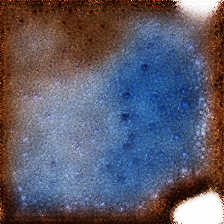

127.0.0.1 - - [11/Dec/2020 20:48:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:48:46] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:49:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:42] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached activations with deepviz_37-186_features_3_preadd_conv:7226_1607737701.3432825.jpg
CALLED: update_inputimg_actmap


127.0.0.1 - - [11/Dec/2020 20:49:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmapCALLED: update_node_inputs

CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:49:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:49:51] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:49:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
Updating cached activations with tiger_beetle_1002.JPEG


127.0.0.1 - - [11/Dec/2020 20:51:55] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:51:56] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with tiger


127.0.0.1 - - [11/Dec/2020 20:51:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:51:59] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:52:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
Updating cached activations with tick_10006.JPEG


127.0.0.1 - - [11/Dec/2020 20:52:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:27] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_node_actmap
CALLED: update_edge_outmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 20:52:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:29] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:52:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:52:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:53:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
Updating cached activations with deepviz_37-186_features_3_preadd_conv:7226_1607737701.3432825.jpg


127.0.0.1 - - [11/Dec/2020 20:53:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:53:46] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmapCALLED: update_edge_outmap



127.0.0.1 - - [11/Dec/2020 20:53:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:53:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:53:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:53:48] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177816    177816  features_8      3          238         216   
177980    177980  features_8      3          238         380   
177813    177813  features_8      3          238         213   
177923    177923  features_8      3          238         323   
177632    177632  features_8      3          238          32   
177744    177744  features_8      3          238         144   
177759    177759  features_8      3          238         159   
177936    177936  features_8      3          238         336   
177753    177753  features_8      3          238         153   
177724    177724  features_8      3          238         124   
177890    177890  features_8      3          238         290   
177818    177818  features_8      3          238         218   
177619    177619  features_8      3          238          19   
177639    177639  features_8      3          238          39   
177965    177965  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:53:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:54:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:54:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:54:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:55:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.

update ranksdf_store triggered
Updating cached rank dfs with breakwater


127.0.0.1 - - [11/Dec/2020 20:56:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
CALLED: update_store

TRIGGER target-signal.children
changing target category to breakwater
        node_num   layer_name  layer  node_num_by_layer  act_prenorm_rank  \
256896         0   features_0      0                  0          0.141904   
256897         1   features_0      0                  1          0.166600   
256898         2   features_0      0                  2          0.247146   
256899         3   features_0      0                  3          0.511405   
256900         4   features_0      0                  4          0.273395   
...          ...          ...    ...                ...               ...   
258043      1147  features_10      4                251          0.200355   
258044      1148  features_10      4                252          0.797891   
258045      1149  features_10      4                253          0.315793   
258046      1150  features_10      4                254          0.087591   
258047      1151  features_10     

127.0.0.1 - - [11/Dec/2020 20:56:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:12] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
177753    177753  features_8      3          238         153   
177672    177672  features_8      3          238          72   
177664    177664  features_8      3          238          64   
177606    177606  features_8      3          238           6   
177954    177954  features_8      3          238         354   
177718    177718  features_8      3          238         118   
177887    177887  features_8      3          238         287   
177642    177642  features_8      3          238          42   
177960    177960  features_8      3          238         360   
177980    177980  features_8      3          238         380   
177774    177774  features_8      3          238         174   
177886    177886  features_8      3          238         286   
177792    177792  features_8      3          238         192   
177641    177641  features_8      3          238          41   
177833    177833  features_8      3     

127.0.0.1 - - [11/Dec/2020 20:56:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186']
['0', '686', '874', '787', '874', '8', '878']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:56:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 20:56:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepvizCALLED: update_node_actmap

CALLED: update_node_inputsfound pre-generated image



127.0.0.1 - - [11/Dec/2020 20:56:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 1058
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
226234    226234  features_10      4          162         250   
226075    226075  features_10      4          162          91   
226098    226098  features_10      4          162         114   
226212    226212  features_10      4          162         228   
226045    226045  features_10      4          162          61   
226210    226210  features_10      4          162         226   
226038    226038  features_10      4          162          54   
226063    226063  features_10      4          162          79   
226107    226107  features_10      4          162         123   
226214    226214  features_10      4          162         230   
226113    226113  features_10      4          162         129   
226092    226092  features_10      4          162         108   
226178    226178  features_10      4          162         194   
226185    226185  features_10      4          162         201   
225992    225992  feature

127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:56:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:56:25] "POST /_dash-update-component HTTP/1.1" 200 -


update ranksdf_store triggered
Updating cached rank dfs with bullfrog


127.0.0.1 - - [11/Dec/2020 20:57:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs
Updating cached activations with deepviz_37-186_features_3_preadd_conv:7226_1607737701.3432825.jpg
CALLED: update_store

TRIGGER target-signal.children
changing target category to bullfrog
        node_num   layer_name  layer  node_num_by_layer  act_prenorm_rank  \
273024         0   features_0      0                  0          0.321595   
273025         1   features_0      0                  1          0.444115   
273026         2   features_0      0                  2          0.449151   
273027         3   features_0      0                  3          0.546847   
273028         4   features_0      0                  4          0.546775   
...          ...          ...    ...                ...               ...   
274171      1147  features_10      4                251          0.316118   
274172      1148  features_10      4                252          0.346532   
274173      1149  features_10      4                253          0.326111   
274174      11

127.0.0.1 - - [11/Dec/2020 20:57:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186']
['0', '686', '874', '787', '874', '8', '878', '1058']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 20:57:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:34] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
226098    226098  features_10      4          162         114   
226045    226045  features_10      4          162          61   
226063    226063  features_10      4          162          79   
226128    226128  features_10      4          162         144   
226013    226013  features_10      4          162          29   
226234    226234  features_10      4          162         250   
226116    226116  features_10      4          162         132   
226059    226059  features_10      4          162          75   
226030    226030  features_10      4          162          46   
226216    226216  features_10      4          162         232   
226040    226040  features_10      4          162          56   
226038    226038  features_10      4          162          54   
226162    226162  features_10      4          162         178   
226018    226018  features_10      4          162          34   
226198    226198  feature

127.0.0.1 - - [11/Dec/2020 20:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 20:57:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 20:57:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 912
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:57:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186']
['0', '686', '874', '787', '874', '8', '878', '1058', '912']
updating edge highlight to 37-186
updating node highlight to 912
4 162 features_10


127.0.0.1 - - [11/Dec/2020 20:57:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:57:53] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
188726    188726  features_10      4           16         118   
188681    188681  features_10      4           16          73   
188740    188740  features_10      4           16         132   
188755    188755  features_10      4           16         147   
188752    188752  features_10      4           16         144   
188664    188664  features_10      4           16          56   
188749    188749  features_10      4           16         141   
188807    188807  features_10      4           16         199   
188786    188786  features_10      4           16         178   
188685    188685  features_10      4           16          77   
188637    188637  features_10      4           16          29   
188791    188791  features_10      4           16         183   
188708    188708  features_10      4           16         100   
188804    188804  features_10      4           16         196   
188625    188625  feature

127.0.0.1 - - [11/Dec/2020 20:58:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 20:58:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:17] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 1135


127.0.0.1 - - [11/Dec/2020 20:58:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
updating edge highlight to 37-186
updating node highlight to 1135
4 16 features_10


127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 20:58:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:20] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 20:58:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:53] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:58:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_inputimg_actmap
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpg


127.0.0.1 - - [11/Dec/2020 20:59:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 20:59:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:59:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:59:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:59:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 20:59:12] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 20:59:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:00:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:04:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:04:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpgCALLED: update_edge_deepviz

found pre-generated image
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpg


127.0.0.1 - - [11/Dec/2020 21:05:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
g-21
changing selected edge to g-21
['r-2', '37-186', 'g-21']


127.0.0.1 - - [11/Dec/2020 21:05:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpgUpdating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpg



127.0.0.1 - - [11/Dec/2020 21:05:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:05:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
updating edge highlight to g-21
updating node highlight to 1135
4 16 features_10


127.0.0.1 - - [11/Dec/2020 21:05:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:12] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:05:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:05:13] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 21:05:14] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:05:14] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpg
CALLED: update_node_inputs
Updating cached activations with deepviz_1135_features_10:239_1607620716.2912247.jpg
Updating cached rank dfs with bullfrog


127.0.0.1 - - [11/Dec/2020 21:06:01] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 21:06:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
g-37
changing selected edge to g-37
['r-2', '37-186', 'g-21', 'g-37']
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:06:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap


127.0.0.1 - - [11/Dec/2020 21:06:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
updating edge highlight to g-37
updating node highlight to 1135
4 16 features_10


127.0.0.1 - - [11/Dec/2020 21:06:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:12] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:06:14] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 21:06:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_actmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:06:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmapCALLED: update_node_inputs



127.0.0.1 - - [11/Dec/2020 21:06:34] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:06:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:06:35] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 21:06:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:08:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [11/Dec/2020 21:09:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:09:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: update_store

TRIGGER edge-thresh-slider.value
changing edge thresholds to 0.079 - 1
found 47 edges


127.0.0.1 - - [11/Dec/2020 21:10:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 21:10:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:10:22] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated imageCALLED: update_edge_deepviz



127.0.0.1 - - [11/Dec/2020 21:10:23] "POST /_dash-update-component HTTP/1.1" 200 -


deepviz image not found, generating . . .
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_store



  0%|          | 0/512 [00:00<?, ?it/s]127.0.0.1 - - [11/Dec/2020 21:10:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:23] "POST /_dash-update-component HTTP/1.1" 200 -
  1%|          | 3/512 [00:00<00:23, 21.69it/s]

Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpgTRIGGER edge-actmaps-input.value

r-59
changing selected edge to r-59
['r-2', '37-186', 'g-21', 'g-37', 'r-59']


  1%|          | 6/512 [00:00<00:22, 22.23it/s]

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [11/Dec/2020 21:10:23] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1936, in dispatch_request
    return self.view

127.0.0.1 - - [11/Dec/2020 21:10:23] "POST /_dash-update-component HTTP/1.1" 500 -
  5%|▍         | 25/512 [00:01<00:21, 23.09it/s]

CALLED: update_edge_kernelmap


  6%|▋         | 32/512 [00:01<00:17, 26.72it/s]

CALLED: update_edge_outmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/m

127.0.0.1 - - [11/Dec/2020 21:10:24] "POST /_dash-update-component HTTP/1.1" 500 -
  9%|▊         | 44/512 [00:01<00:16, 27.94it/s]127.0.0.1 - - [11/Dec/2020 21:10:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:25] "POST /_dash-update-component HTTP/1.1" 200 -
 10%|▉         | 51/512 [00:01<00:15, 29.47it/s]

CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
updating edge highlight to r-59
updating node highlight to 1135
4 16 features_10


 12%|█▏        | 59/512 [00:02<00:15, 29.15it/s]

CALLED: update_edge_inmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/chris/miniconda3/envs/pruning_viz/lib/python3.6/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/mi

127.0.0.1 - - [11/Dec/2020 21:10:25] "POST /_dash-update-component HTTP/1.1" 500 -
 73%|███████▎  | 375/512 [00:11<00:03, 34.68it/s]127.0.0.1 - - [11/Dec/2020 21:10:34] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:34] "POST /_dash-update-component HTTP/1.1" 200 -
100%|██████████| 512/512 [00:14<00:00, 34.26it/s]



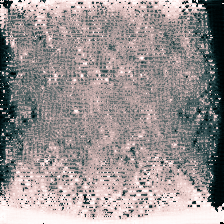

127.0.0.1 - - [11/Dec/2020 21:10:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:10:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:10:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:10:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected edge to 37-186
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']


127.0.0.1 - - [11/Dec/2020 21:10:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_edge_outmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:10:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['0', '686', '874', '787', '874', '8', '878', '1058', '912', '1135']
updating edge highlight to 37-186
updating node highlight to 1135
4 16 features_10
CALLED: update_edge_inmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:10:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:10:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:11:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.

Updating cached rank dfs with bullfrog


127.0.0.1 - - [11/Dec/2020 21:11:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:11:37] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
245843    245843  features_10      4          239         147   
245828    245828  features_10      4          239         132   
245895    245895  features_10      4          239         199   
245928    245928  features_10      4          239         232   
245788    245788  features_10      4          239          92   
245769    245769  features_10      4          239          73   
245874    245874  features_10      4          239         178   
245832    245832  features_10      4          239         136   
245831    245831  features_10      4          239         135   
245906    245906  features_10      4          239         210   
245840    245840  features_10      4          239         144   
245725    245725  features_10      4          239          29   
245773    245773  features_10      4          239          77   
245930    245930  features_10      4          239         234   
245810    245810  feature

127.0.0.1 - - [11/Dec/2020 21:11:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:12:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz


127.0.0.1 - - [11/Dec/2020 21:12:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:12:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:57] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 1044
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:12:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['686', '874', '787', '874', '8', '878', '1058', '912', '1135', '1044']
updating edge highlight to 37-186
updating node highlight to 1044
4 239 features_10


127.0.0.1 - - [11/Dec/2020 21:12:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:12:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
222532    222532  features_10      4          148         132   
222632    222632  features_10      4          148         232   
222593    222593  features_10      4          148         193   
222479    222479  features_10      4          148          79   
222472    222472  features_10      4          148          72   
222518    222518  features_10      4          148         118   
222519    222519  features_10      4          148         119   
222456    222456  features_10      4          148          56   
222441    222441  features_10      4          148          41   
222573    222573  features_10      4          148         173   
222477    222477  features_10      4          148          77   
222475    222475  features_10      4          148          75   
222480    222480  features_10      4          148          80   
222447    222447  features_10      4          148          47   
222616    222616  feature

127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:13:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:13:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:13:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 839
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:13:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['874', '787', '874', '8', '878', '1058', '912', '1135', '1044', '839']
updating edge highlight to 37-186
updating node highlight to 839
4 148 features_10


127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:13:43] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
163004    163004  features_8      3          199         380   
162874    162874  features_8      3          199         250   
162757    162757  features_8      3          199         133   
162685    162685  features_8      3          199          61   
162790    162790  features_8      3          199         166   
162815    162815  features_8      3          199         191   
162837    162837  features_8      3          199         213   
163005    163005  features_8      3          199         381   
163007    163007  features_8      3          199         383   
162783    162783  features_8      3          199         159   
162903    162903  features_8      3          199         279   
162792    162792  features_8      3          199         168   
162961    162961  features_8      3          199         337   
162654    162654  features_8      3          199          30   
162913    162913  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:14:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:04] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
162837    162837  features_8      3          199         213   
162685    162685  features_8      3          199          61   
162815    162815  features_8      3          199         191   
162867    162867  features_8      3          199         243   
162757    162757  features_8      3          199         133   
162783    162783  features_8      3          199         159   
162649    162649  features_8      3          199          25   
162767    162767  features_8      3          199         143   
162712    162712  features_8      3          199          88   
162874    162874  features_8      3          199         250   
163007    163007  features_8      3          199         383   
162987    162987  features_8      3          199         363   
162863    162863  features_8      3          199         239   
162790    162790  features_8      3          199         166   
162632    162632  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:14:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['874', '787', '874', '8', '878', '1058', '912', '1135', '1044', '839']
building graph from browser "state"


127.0.0.1 - - [11/Dec/2020 21:14:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:14:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:14:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 787
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:14:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:23] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
142777    142777  features_8      3          147         121   
142952    142952  features_8      3          147         296   
142970    142970  features_8      3          147         314   
142822    142822  features_8      3          147         166   
142724    142724  features_8      3          147          68   
142900    142900  features_8      3          147         244   
143036    143036  features_8      3          147         380   
142869    142869  features_8      3          147         213   
142930    142930  features_8      3          147         274   
142717    142717  features_8      3          147          61   
142719    142719  features_8      3          147          63   
143039    143039  features_8      3          147         383   
142891    142891  features_8      3          147         235   
142824    142824  features_8      3          147         168   
142660    142660  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:14:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:14:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:14:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:41] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 839


127.0.0.1 - - [11/Dec/2020 21:14:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:42] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:44] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['874', '8', '878', '1058', '912', '1135', '1044', '839', '787', '839']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 839
3 147 features_8
        edge_num  layer_name  layer  out_channel  in_channel  \
162837    162837  features_8      3          199         213   
162685    162685  features_8      3          199          61   
162815    162815  features_8      3          199         191   
162867    162867  features_8      3          199         243   
162757    162757  features_8      3          199         133   
162783    162783  features_8      3          199         159   
162649    162649  features_8      3          199          25   
162767    162767  features_8      3          199         143   
162712    162712  features_8      3          199          88   
162874    162874  features_8      3          199         250   
163

127.0.0.1 - - [11/Dec/2020 21:14:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:14:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:15:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_actmap
CALLED: update_node_inputs
found pre-generated image
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:15:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 772
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 21:15:04] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:15:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.

        edge_num  layer_name  layer  out_channel  in_channel  \
137170    137170  features_8      3          132         274   
136995    136995  features_8      3          132          99   
136915    136915  features_8      3          132          19   
136993    136993  features_8      3          132          97   
137192    137192  features_8      3          132         296   
137276    137276  features_8      3          132         380   
137037    137037  features_8      3          132         141   
137139    137139  features_8      3          132         243   
137182    137182  features_8      3          132         286   
137077    137077  features_8      3          132         181   
137062    137062  features_8      3          132         166   
136959    136959  features_8      3          132          63   
137219    137219  features_8      3          132         323   
136900    136900  features_8      3          132           4   
137087    137087  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:15:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:15:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:26] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 21:15:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:15:49] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 839
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:15:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_edge_outmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:15:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['878', '1058', '912', '1135', '1044', '839', '787', '839', '772', '839']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 839
3 132 features_8


127.0.0.1 - - [11/Dec/2020 21:15:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:54] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:15:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.

        edge_num  layer_name  layer  out_channel  in_channel  \
162837    162837  features_8      3          199         213   
162685    162685  features_8      3          199          61   
162815    162815  features_8      3          199         191   
162867    162867  features_8      3          199         243   
162757    162757  features_8      3          199         133   
162783    162783  features_8      3          199         159   
162649    162649  features_8      3          199          25   
162767    162767  features_8      3          199         143   
162712    162712  features_8      3          199          88   
162874    162874  features_8      3          199         250   
163007    163007  features_8      3          199         383   
162987    162987  features_8      3          199         363   
162863    162863  features_8      3          199         239   
162790    162790  features_8      3          199         166   
162632    162632  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:16:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:16:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:18:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepvizCALLED: update_node_actmap
CALLED: update_node_inputs

found pre-generated image
CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 245


127.0.0.1 - - [11/Dec/2020 21:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:22] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with bullfrog
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 21:18:23] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap
CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['1058', '912', '1135', '1044', '839', '787', '839', '772', '839', '245']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 245
3 199 features_8


127.0.0.1 - - [11/Dec/2020 21:18:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:24] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:18:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:25] "POST /_dash-update-component HTTP/1.1" 200 -


       edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
11831     11831  features_3      1          181          55          1.806961   
11833     11833  features_3      1          181          57          1.672488   
11804     11804  features_3      1          181          28          1.867556   
11792     11792  features_3      1          181          16          1.577934   
11817     11817  features_3      1          181          41          1.515774   
11839     11839  features_3      1          181          63          1.349696   
11799     11799  features_3      1          181          23          1.698279   
11784     11784  features_3      1          181           8          1.516623   
11800     11800  features_3      1          181          24          1.504661   
11806     11806  features_3      1          181          30          1.425396   
11810     11810  features_3      1          181          34          1.311699   
11825     11825  features_3 

127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:18:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 21:19:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
CALLED: update_node_inputs
found pre-generated image
CALLED: update_node_actmap
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 1074
CALLED: update_edge_kernelmap


127.0.0.1 - - [11/Dec/2020 21:19:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:37] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:19:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:37] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['912', '1135', '1044', '839', '787', '839', '772', '839', '245', '1074']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 1074
1 181 features_3


127.0.0.1 - - [11/Dec/2020 21:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:38] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:19:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:19:39] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num   layer_name  layer  out_channel  in_channel  \
230279    230279  features_10      4          178         199   
230290    230290  features_10      4          178         210   
230160    230160  features_10      4          178          80   
230126    230126  features_10      4          178          46   
230227    230227  features_10      4          178         147   
230258    230258  features_10      4          178         178   
230198    230198  features_10      4          178         118   
230277    230277  features_10      4          178         197   
230121    230121  features_10      4          178          41   
230285    230285  features_10      4          178         205   
230257    230257  features_10      4          178         177   
230334    230334  features_10      4          178         254   
230194    230194  features_10      4          178         114   
230164    230164  features_10      4          178          84   
230115    230115  feature

127.0.0.1 - - [11/Dec/2020 21:20:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:20:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:21:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [11/Dec/2020 21:22:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:22:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:23:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-186
changing selected node to 864CALLED: update_node_deepviz
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg



127.0.0.1 - - [11/Dec/2020 21:24:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:00] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_node_actmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_node_inputs
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:24:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['1135', '1044', '839', '787', '839', '772', '839', '245', '1074', '864']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 864
4 178 features_10


127.0.0.1 - - [11/Dec/2020 21:24:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:24:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:08] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.

CALLED: switch_node_actmap_click
CALLED: switch_edge_actmaps_click


127.0.0.1 - - [11/Dec/2020 21:24:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_deepviz
found pre-generated image
CALLED: update_node_actmap
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg
CALLED: update_node_inputs
Updating cached activations with deepviz_g-37_features_0_preadd_conv:101_1607613312.76379.jpg


127.0.0.1 - - [11/Dec/2020 21:24:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:45] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 880
CALLED: update_edge_deepviz
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:24:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:46] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_kernelmap
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 21:24:47] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:49] "POST /_dash-update-component HTTP/1.1" 200 -


Updating cached rank dfs with bullfrog


127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['1044', '839', '787', '839', '772', '839', '245', '1074', '864', '880']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 880
3 224 features_8


127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:24:51] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
172300    172300  features_8      3          224          76   
172486    172486  features_8      3          224         262   
172538    172538  features_8      3          224         314   
172340    172340  features_8      3          224         116   
172258    172258  features_8      3          224          34   
172249    172249  features_8      3          224          25   
172242    172242  features_8      3          224          18   
172459    172459  features_8      3          224         235   
172240    172240  features_8      3          224          16   
172288    172288  features_8      3          224          64   
172513    172513  features_8      3          224         289   
172438    172438  features_8      3          224         214   
172415    172415  features_8      3          224         191   
172453    172453  features_8      3          224         229   
172272    172272  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:25:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:05] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
178644    178644  features_8      3          240         276   
178601    178601  features_8      3          240         233   
178466    178466  features_8      3          240          98   
178573    178573  features_8      3          240         205   
178484    178484  features_8      3          240         116   
178481    178481  features_8      3          240         113   
178592    178592  features_8      3          240         224   
178705    178705  features_8      3          240         337   
178545    178545  features_8      3          240         177   
178436    178436  features_8      3          240          68   
178625    178625  features_8      3          240         257   
178544    178544  features_8      3          240         176   
178541    178541  features_8      3          240         173   
178607    178607  features_8      3          240         239   
178603    178603  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:25:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: switch_node_actmap_click
CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:25:15] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
37-186
changing selected node to 744
CALLED: update_node_deepviz
found pre-generated image
CALLED: update_node_actmap


127.0.0.1 - - [11/Dec/2020 21:25:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_node_inputs


127.0.0.1 - - [11/Dec/2020 21:25:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['839', '787', '839', '772', '839', '245', '1074', '864', '880', '744']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 744
3 240 features_8


127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:18] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
126335    126335  features_8      3          104         191   
126235    126235  features_8      3          104          91   
126493    126493  features_8      3          104         349   
126403    126403  features_8      3          104         259   
126379    126379  features_8      3          104         235   
126313    126313  features_8      3          104         169   
126290    126290  features_8      3          104         146   
126225    126225  features_8      3          104          81   
126210    126210  features_8      3          104          66   
126185    126185  features_8      3          104          41   
126310    126310  features_8      3          104         166   
126205    126205  features_8      3          104          61   
126419    126419  features_8      3          104         275   
126482    126482  features_8      3          104         338   
126418    126418  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:25:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:25:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:32] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:25:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:25:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:36] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 870
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:25:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['787', '839', '772', '839', '245', '1074', '864', '880', '744', '870']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 870
3 104 features_8


127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:39] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
174600    174600  features_8      3          230          72   
174763    174763  features_8      3          230         235   
174780    174780  features_8      3          230         252   
174719    174719  features_8      3          230         191   
174705    174705  features_8      3          230         177   
174620    174620  features_8      3          230          92   
174591    174591  features_8      3          230          63   
174615    174615  features_8      3          230          87   
174658    174658  features_8      3          230         130   
174772    174772  features_8      3          230         244   
174547    174547  features_8      3          230          19   
174801    174801  features_8      3          230         273   
174816    174816  features_8      3          230         288   
174840    174840  features_8      3          230         312   
174675    174675  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:25:51] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_actmap
CALLED: update_node_deepviz
CALLED: update_node_inputs
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:25:51] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
found pre-generated image
CALLED: update_edge_kernelmap
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 764
CALLED: update_edge_inmap


127.0.0.1 - - [11/Dec/2020 21:25:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:25:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:55] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
133892    133892  features_8      3          124          68   
134116    134116  features_8      3          124         292   
134161    134161  features_8      3          124         337   
134204    134204  features_8      3          124         380   
133945    133945  features_8      3          124         121   
134199    134199  features_8      3          124         375   
133968    133968  features_8      3          124         144   
134117    134117  features_8      3          124         293   
134001    134001  features_8      3          124         177   
133887    133887  features_8      3          124          63   
133871    133871  features_8      3          124          47   
134075    134075  features_8      3          124         251   
133946    133946  features_8      3          124         122   
134167    134167  features_8      3          124         343   
133849    133849  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['839', '772', '839', '245', '1074', '864', '880', '744', '870', '764']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 764
3 230 features_8


127.0.0.1 - - [11/Dec/2020 21:25:56] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:25:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:26:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:01] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
CALLED: update_node_actmap
found pre-generated image


127.0.0.1 - - [11/Dec/2020 21:26:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:02] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_deepviz
CALLED: update_edge_kernelmap
found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 791
CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:26:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:05] "POST /_dash-update-component HTTP/1.1" 200 -


        edge_num  layer_name  layer  out_channel  in_channel  \
144367    144367  features_8      3          151         175   
144488    144488  features_8      3          151         296   
144255    144255  features_8      3          151          63   
144572    144572  features_8      3          151         380   
144427    144427  features_8      3          151         235   
144217    144217  features_8      3          151          25   
144392    144392  features_8      3          151         200   
144468    144468  features_8      3          151         276   
144469    144469  features_8      3          151         277   
144515    144515  features_8      3          151         323   
144335    144335  features_8      3          151         143   
144290    144290  features_8      3          151          98   
144279    144279  features_8      3          151          87   
144485    144485  features_8      3          151         293   
144364    144364  features_8      3     

127.0.0.1 - - [11/Dec/2020 21:26:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:06] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:26:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [11/Dec/2020 21:26:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:18] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click
CALLED: update_node_deepviz
CALLED: update_node_inputs
found pre-generated imageCALLED: update_node_actmap

CALLED: update_edge_deepviz


127.0.0.1 - - [11/Dec/2020 21:26:18] "POST /_dash-update-component HTTP/1.1" 200 -


found pre-generated image
CALLED: update_store

TRIGGER edge-actmaps-input.value
37-186
changing selected node to 672
CALLED: update_edge_kernelmap


127.0.0.1 - - [11/Dec/2020 21:26:19] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_edge_inmap
CALLED: update_edge_outmap


127.0.0.1 - - [11/Dec/2020 21:26:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:20] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.1, 1]
['r-2', '37-186', 'g-21', 'g-37', 'r-59', '37-186']
['839', '245', '1074', '864', '880', '744', '870', '764', '791', '672']
updating edge highlight to 37-186
select edge, 37-186,  not recolored as no longer shown
updating node highlight to 672
3 151 features_8


127.0.0.1 - - [11/Dec/2020 21:26:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_inputimg_dropdown options


127.0.0.1 - - [11/Dec/2020 21:26:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:22] "POST /_dash-update-component HTTP/1.1" 200 -


       edge_num  layer_name  layer  out_channel  in_channel  act_prenorm_rank  \
98672     98672  features_8      3           32         176          0.371283   
98796     98796  features_8      3           32         300          0.162214   
98810     98810  features_8      3           32         314          0.213856   
98696     98696  features_8      3           32         200          0.206008   
98669     98669  features_8      3           32         173          0.126497   
98635     98635  features_8      3           32         139          0.130541   
98698     98698  features_8      3           32         202          0.145189   
98613     98613  features_8      3           32         117          0.383423   
98500     98500  features_8      3           32           4          0.129226   
98612     98612  features_8      3           32         116          0.116817   
98542     98542  features_8      3           32          46          0.139237   
98523     98523  features_8 

127.0.0.1 - - [11/Dec/2020 21:26:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:26:43] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:07] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2020 21:27:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.

In [ ]:
app.run_server(port=8050)